In [2]:
from numpy import linalg as LA
import numpy as np
import pandas as pd
import math
import networkx as nx
import community
import matplotlib.pyplot as plt
from statsmodels.stats import multitest
from scipy import stats

In [3]:
def compute_C_minus_C0(lambdas,v,lambda_plus,removeMarketMode=True):
    N=len(lambdas)
    C_clean=np.zeros((N, N))
    
    order = np.argsort(lambdas)
    lambdas,v = lambdas[order],v[:,order]
    
    v_m=np.matrix(v)

    # note that the eivenvalues are sorted
    for i in range(1*removeMarketMode,N):                            
        if lambdas[i]>lambda_plus: 
            C_clean=C_clean+lambdas[i] * np.dot(v_m[:,i],v_m[:,i].T)  
    return C_clean    
    
    
def LouvainCorrelationClustering(R):   # R is a matrix of return
    N=R.shape[1]
    T=R.shape[0]

    q=N*1./T
    lambda_plus=(1.+np.sqrt(q))**2

    C=R.corr()
    lambdas, v = LA.eigh(C)

    C_s=compute_C_minus_C0(lambdas,v,lambda_plus)
    
    mygraph= nx.from_numpy_array(np.abs(C_s))
    partition = community.community_louvain.best_partition(mygraph)

    DF=pd.DataFrame.from_dict(partition,orient="index")
    return (DF) 

def FDR(data, alpha=0.05, null_mean=0):
    pvals=[]
    for ticker in data.columns:
        _, p_value = stats.ttest_1samp(data[ticker], null_mean)
        pvals.append(p_value)
    rej, _,_,_ = multitest.multipletests(pvals, alpha=alpha, method='fdr_bh')

    return rej

def market_state_strategy(r, seed=10, addFDR=False): #matrix of log returns
    np.random.seed(seed)

    T=int(np.floor(r.shape[1]/3))
    ret=[0]
    for t in range(T+1,r.shape[0]):
        R = r.iloc[t-T:t]
        DF = LouvainCorrelationClustering(R.T)
        cur_state=DF.iloc[-1][0]
        I = DF[DF[0]==cur_state].index.tolist()
        my_list = [x+1 for x in I[:-1]]

        if not addFDR:
            ar=R.iloc[my_list].mean(axis=0) #normal
            pos = np.sign(ar.values) #normal
        else:
            rej=FDR(R.iloc[my_list], alpha=0.1) # fdr 
            ar=R.iloc[my_list].mean(axis=0)
            pos = np.sign(ar.values)
            pos[~rej] = 0 # fdr

        ret.append(np.dot(pos, np.exp(r.iloc[t].values)-1)/len(pos))

    all_ret=pd.DataFrame({'Strat_A':ret}, index=r.index[T:])
    all_ret['buy_and_hold']=np.concatenate(([0], np.dot(np.exp(r.iloc[T+1:])-1, np.ones(len(pos)))/len(pos)))
    all_ret['Strat_A_perf']=all_ret['Strat_A']+1
    all_ret['Strat_A_perf'].cumprod().plot(label='market_state_strategy')

    all_ret['BH_perf']=all_ret['buy_and_hold']+1
    all_ret['BH_perf'].cumprod().plot(label='buy_and_hold')
    plt.xlabel('time')
    plt.ylabel('USD')
    plt.title('Cumulative_performance')
    plt.legend()
    plt.show()

# 2007-2008

In [5]:
import matplotlib.cm as cm
import yfinance as yf

alldata=pd.read_csv(r"D:\Document\EPFL_Coursework\FinancialBigData\clean\us_equities_logreturns.csv.gz")
alldata.drop(columns=["Unnamed: 0","^GSPC"], inplace=True)
tickers=alldata.columns.tolist()

all_data = pd.DataFrame()
for ticker in tickers:
    try:
        data = yf.download(ticker, start="2020-08-01", end="2021-01-01",progress=False)
        all_data[ticker] = data['Close']
    except Exception as e:
        print(f"Failed to retrieve data for {ticker}. Error: {e}")

# print(all_data.head())
data_subset=all_data.dropna(axis=1)
log_return=np.log(data_subset).diff()
log_return.head()


1 Failed download:
['UTX']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['NAV']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['AET']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-08-01 -> 2021-01-01)')

1 Failed download:
['CNW']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-08-01 -> 2021-01-01)')

1 Failed download:
['MOT']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-08-01 -> 2021-01-01)')

1 Failed download:
['DBD']: Exception("%ticker%: Data doesn't exist for startDate = 1596254400, endDate = 1609477200")

1 Failed download:
['RSH']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-08-01 -> 2021-01-01)')

1 Failed download:
['RTN']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['AVP']: Exception('%ticker%: No timezone found, symbol may be delisted')


,GE,IBM,DIS,BA,CAT,AA,HPQ,DD,KO,XOM,...,FAF,CEM,VSH,BIO,GM,FF,FIF,BFS,CTR,KIM
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-04,0.004898,0.012233,0.008047,0.017108,-0.001975,-0.000731,0.006730,0.013255,0.008388,0.028467,...,0.020084,0.028287,0.041495,-0.007902,0.006221,-0.006826,-0.001986,0.029390,0.026058,0.039775
2020-08-05,0.041473,-0.003104,0.084329,0.054294,0.025894,0.071282,0.004462,0.029106,0.011288,0.008704,...,0.002061,0.045220,0.017186,0.000835,0.020335,0.015855,0.008906,0.003249,0.027673,-0.019248
2020-08-06,-0.010998,0.005327,0.024844,-0.012007,-0.004307,0.014875,0.016557,-0.000366,0.005491,-0.004801,...,-0.003751,0.013562,-0.004711,-0.003952,0.010954,0.026609,0.001969,0.001297,0.031346,0.010545
2020-08-07,0.010998,-0.009240,-0.006827,-0.012740,0.003936,-0.015557,0.010887,0.020981,0.006717,-0.004594,...,0.013253,0.015909,-0.012474,-0.002077,0.003749,0.042134,0.000983,0.020203,-0.002207,0.041940


In [11]:
def FDR(data, alpha=0.05, null_mean=0):
    pvals=[]
    for ticker in data.columns:
        t_statistic, p_value = stats.ttest_1samp(data[ticker], null_mean)
        pvals.append(p_value)
    rej, _, _, _ = multitest.multipletests(pvals, alpha=alpha, method='fdr_bh')
    return rej

r=log_return
T=int(np.floor(r.shape[1]/3))
ret=[1]
for t in range(T+1,T+2):
    R = r.iloc[t-T:t]
    df = LouvainCorrelationClustering(R.T)
    pre_state=df.iloc[-1][0]
    I = df[df[0]==pre_state].index.tolist()
    my_list = [x+1 for x in I[:-1]]
    rej=FDR(R.iloc[my_list])
    ar=R.iloc[my_list].mean(axis=0)
    pos = np.sign(ar.values)
    pos[~rej] = 0
    ret.append(np.dot(pos, np.exp(r.iloc[t].values)-1)/len(pos)+1)



IndexError: single positional indexer is out-of-bounds

C:\Users\E.M.Lau\AppData\Local\Temp\ipykernel_15572\650695569.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_chopped['rolling_ret']=ret
C:\Users\E.M.Lau\AppData\Local\Temp\ipykernel_15572\650695569.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chopped['rolling_ret']=ret
C:\Users\E.M.Lau\AppData\Local\Temp\ipykernel_15572\650695569.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining 

Text(0.5, 1.0, 'Cumulative_return')

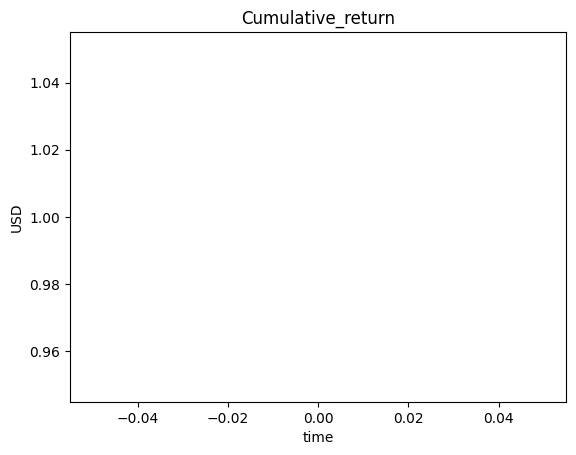

In [9]:
# data_subset=all_data.dropna(axis=1)
# r=np.log(data_subset).diff()
r=log_return
T=int(np.floor(r.shape[1]/3))
ret=[1]
for t in range(T+1,r.shape[0]):
    R = r.iloc[t-T:t]
    df = LouvainCorrelationClustering(R.T)
    pre_state=df.iloc[T-1][0]
    I = df[df[0]==pre_state].index.tolist()
    my_list = [x+1 for x in I[:-1]]
    ar=R.iloc[my_list].mean(axis=0)
    pos = np.sign(ar.values)
    ret.append(np.dot(pos, np.exp(r.iloc[t].values)-1)/len(pos)+1)

df_chopped = r.iloc[T:]
df_chopped['rolling_ret']=ret
df_chopped['cumulative_perf']=df_chopped['rolling_ret'].cumprod()
df_chopped['cumulative_perf'].plot()
plt.xlabel('time')
plt.ylabel('USD')
plt.title('Cumulative_return')

# Intraday test

In [14]:
# from market_state_strategy import market_state_strategy
from upload_data import load_all
import pandas as pd

df = load_all(start_date = pd.to_datetime('2007-04-15'), end_date=pd.to_datetime('2007-4-30'), dirBase="data/raw/equities/")

df.info()


No data in the given period for ticker ORCL.N
No data in the given period for ticker MSFT.O
load_TRTH_bbo could not load data/raw/equities//US/bbo/APA.N/2007-04-16-APA.N-bbo.parquet
load_TRTH_bbo could not load data/raw/equities//US/bbo/APA.N/2007-04-17-APA.N-bbo.parquet
load_TRTH_bbo could not load data/raw/equities//US/bbo/APA.N/2007-04-18-APA.N-bbo.parquet
load_TRTH_bbo could not load data/raw/equities//US/bbo/APA.N/2007-04-19-APA.N-bbo.parquet
load_TRTH_bbo could not load data/raw/equities//US/bbo/APA.N/2007-04-20-APA.N-bbo.parquet
load_TRTH_bbo could not load data/raw/equities//US/bbo/APA.N/2007-04-23-APA.N-bbo.parquet
load_TRTH_bbo could not load data/raw/equities//US/bbo/APA.N/2007-04-24-APA.N-bbo.parquet
load_TRTH_bbo could not load data/raw/equities//US/bbo/APA.N/2007-04-25-APA.N-bbo.parquet
load_TRTH_bbo could not load data/raw/equities//US/bbo/APA.N/2007-04-26-APA.N-bbo.parquet
load_TRTH_bbo could not load data/raw/equities//US/bbo/APA.N/2007-04-27-APA.N-bbo.parquet
load_TRT

In [11]:
# grouped = df.set_index(['ticker'])
df2=df.set_index(['ticker'], append=True, inplace=False)
result=df2[['trade_price']]
all=result.unstack(level='ticker')
all_fill = all.ffill().bfill()


C:\Users\E.M.Lau\AppData\Local\Temp\ipykernel_15572\1014571559.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chopped['rolling_ret']=ret
C:\Users\E.M.Lau\AppData\Local\Temp\ipykernel_15572\1014571559.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chopped['cumulative_perf']=df_chopped['rolling_ret'].cumprod()


Text(0.5, 1.0, 'Cumulative_return')

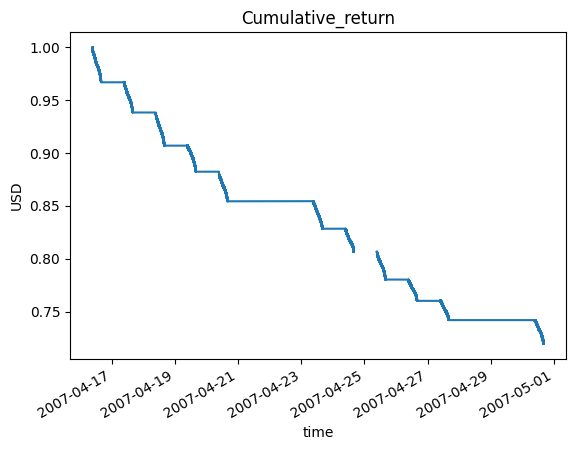

In [12]:
# from numpy import linalg as LA
import numpy as np
# import pandas as pd
# import math
# import networkx as nx
# import community
# import matplotlib.pyplot as plt

# all_reset = all_fill.reset_index(drop=True)
r=np.log(all_fill).diff()
# r.tail()
T=int(np.floor(r.shape[1]/3))
ret=[1]
for t in range(T+1,r.shape[0]):
    R = r.iloc[t-T:t]
    df = LouvainCorrelationClustering(R.T)
    pre_state=df.iloc[T-1][0]
    I = df[df[0]==pre_state].index.tolist()
    my_list = [x+1 for x in I[:-1]]
    ar=R.iloc[my_list].mean(axis=0)
    pos = np.sign(ar.values)
    ret.append(np.dot(pos, np.exp(r.iloc[t].values)-1)/len(pos)+1)

df_chopped = r.iloc[T:]
df_chopped['rolling_ret']=ret
df_chopped['cumulative_perf']=df_chopped['rolling_ret'].cumprod()
df_chopped['cumulative_perf'].plot()
plt.xlabel('time')
plt.ylabel('USD')
plt.title('Cumulative_return')
# market_state_strategy(r)

# clusters by minutes

In [7]:
filepath1=r"D:\Document\EPFL_Coursework\FinancialBigData\clean\2007-01-01-to-2007-01-31-vwap.parquet"
filepath2=r"D:\Document\EPFL_Coursework\FinancialBigData\clean\2007-02-01-to-2007-02-28-vwap.parquet"
filepath3=r"D:\Document\EPFL_Coursework\FinancialBigData\clean\2007-03-01-to-2007-04-30-vwap.parquet"
df1=pd.read_parquet(filepath1)
df2=pd.read_parquet(filepath2)
df3=pd.read_parquet(filepath3)
df = pd.concat([df1, df2, df3])
# df2=df.set_index(['minute','ticker'])
# result=df2['vwap']
all=df.set_index(['minute','ticker']).unstack(level='ticker')

df1.set_index(['minute','ticker']).unstack(level='ticker')
#all.info()


vwap             ...                      
ticker                 AA.N      ABT.N  ...      XOM.N      XRX.N
minute                                  ...                      
2007-01-03 14:30        NaN  48.833295  ...        NaN  16.969097
2007-01-03 14:31  29.886544  48.924805  ...        NaN  16.979139
2007-01-03 14:32  29.902933  48.979192  ...  75.669337  17.017634
2007-01-03 14:33  29.950623  48.998300  ...  75.703973  17.060000
2007-01-03 14:34  29.979737  48.979465  ...  75.514586  17.066284
...                     ...        ...  ...        ...        ...
2007-01-31 20:55  32.342440  53.019104  ...  74.496065  17.199146
2007-01-31 20:56  32.336449  53.001100  ...  74.442696  17.200000
2007-01-31 20:57  32.335146  52.997829  ...  74.456002  17.198929
2007-01-31 20:58  32.312291  52.981176  ...  74.270007  17.188710
2007-01-31 20:59  32.297463  52.988022  ...  74.266910  17.190583

[7800 rows x 82 columns]

In [3]:
all_fill = all.ffill().bfill()
r=np.log(all_fill).diff()

# r.head()

vwap                                                \
ticker                AA.N     ABT.N     AEP.N     ALL.N     AVP.N AXP.N   
minute                                                                     
2007-01-03 14:30       NaN       NaN       NaN       NaN       NaN   NaN   
2007-01-03 14:31  0.000000  0.001872  0.000000  0.002321  0.002926   0.0   
2007-01-03 14:32  0.000548  0.001111  0.000452  0.002795  0.001714   0.0   
2007-01-03 14:33  0.001594  0.000390  0.002178  0.002450  0.001814   0.0   
2007-01-03 14:34  0.000972 -0.000384  0.001569  0.000240  0.000240   0.0   

                                                         ...            \
ticker                BA.N     BAC.N     BAX.N    BHI.N  ...     USB.N   
minute                                                   ...             
2007-01-03 14:30       NaN       NaN       NaN      NaN  ...       NaN   
2007-01-03 14:31 -0.000243  0.000421  0.001649  0.00000  ...  0.009991   
2007-01-03 14:32  0.002606  0.000409  0.000428  0.00000  ...  0.002070   
2007-01-03 14:33  0.002929  0.001155  0.003258  0.00000  ...  0.001169   
2007-01-03 14:34 -0.001462  0.002929  0.001006 -0.00746  ...  0.000523   

                                                                               \
ticker               UTX.N VZ.N     WAG.N WFC.N     WMB.N     WMT.N      WY.N   
minute                                                                          
2007-01-03 14:30       NaN  NaN       NaN   NaN       NaN       NaN       NaN   
2007-01-03 14:31  0.005463  0.0  0.005988   0.0  0.000000  0.000683  0.000000   
2007-01-03 14:32 -0.000085  0.0  0.002671   0.0  0.000000  0.000550  0.000000   
2007-01-03 14:33  0.000537  0.0  0.001160   0.0 -0.004210  0.002283  0.003155   
2007-01-03 14:34 -0.000082  0.0 -0.001137   0.0 -0.004731  0.002832  0.002551   

                                      
ticker               XOM.N     XRX.N  
minute                                
2007-01-03 14:30       NaN       NaN  
2007-01-03 14:31  0.000000  0.000592  
2007-01-03 14:32  0.000000  0.002265  
2007-01-03 14:33  0.000458  0.002486  
2007-01-03 14:34 -0.002505  0.000368  

[5 rows x 82 columns]

In [9]:
def FDR(data, alpha=0.05, null_mean=0):
    pvals=[]
    for ticker in data.columns:
        _, p_value = stats.ttest_1samp(data[ticker], null_mean)
        pvals.append(p_value)
    rej, _,_,_ = multitest.multipletests(pvals, alpha=alpha, method='fdr_bh')

    # pvals_sortind = np.argsort(pvals)
    # pvals_sorted = np.take(pvals, pvals_sortind)
    # nobs = len(pvals_sorted)
    # ecdffactor =  np.arange(1,nobs+1)/float(nobs)
    # reject = pvals_sorted <= ecdffactor*alpha
    # if reject.any():
    #     rejectmax = max(np.nonzero(reject)[0])
    #     reject[:rejectmax] = True
    return rej

T=int(np.floor(r.shape[1]/3))
ret=[1]
for t in range(T+11,T+12):
    R = r.iloc[t-T:t]
    # print(R)
    df = LouvainCorrelationClustering(R.T)
    pre_state=df.iloc[-1][0]
    I = df[df[0]==pre_state].index.tolist()
    my_list = [x+1 for x in I[:-1]]
    # sample=R.iloc[my_list]
    # print(sample)

    # null_mean=0
    # alpha=0.6
    # pvals=[]
    # for ticker in sample.columns:
    #     _, p_value = stats.ttest_1samp(sample[ticker], null_mean)
    #     pvals.append(p_value)
    # pvals_sortind = np.argsort(pvals)
    # pvals_sorted = np.take(pvals, pvals_sortind)
    # nobs = len(pvals_sorted)
    # ecdffactor =  np.arange(1,nobs+1)/float(nobs)
    # rs=ecdffactor*alpha
    # reject = pvals_sorted <= ecdffactor*alpha
    # if reject.any():
    #     rejectmax = max(np.nonzero(reject)[0])
    #     reject[:rejectmax] = True

    rej=FDR(R.iloc[my_list], alpha=0.7)
    ar=R.iloc[my_list].mean(axis=0)
    pos = np.sign(ar.values)
    pos[~rej] = 0
    ret.append(np.dot(pos, np.exp(r.iloc[t].values)-1)/len(pos)+1)

C:\Users\E.M.Lau\AppData\Local\Temp\ipykernel_8880\833146811.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chopped['rolling_ret']=ret
C:\Users\E.M.Lau\AppData\Local\Temp\ipykernel_8880\833146811.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chopped['cumulative_perf']=df_chopped['rolling_ret'].cumprod()


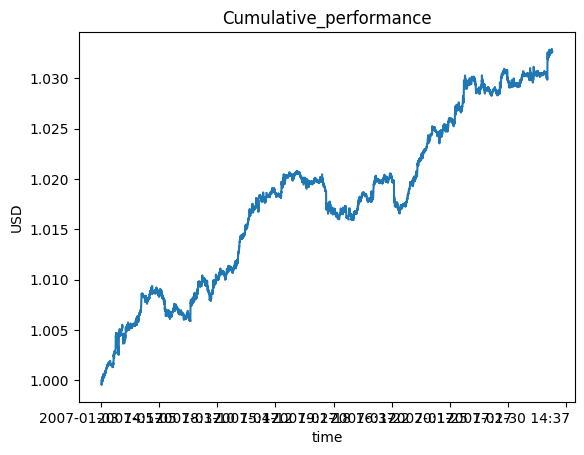

In [22]:
market_state_strategy(r)

In [4]:
T=int(np.floor(r.shape[1]/3))
kkk=np.concatenate(([0], np.dot(np.exp(r.iloc[T+1:])-1, np.ones(r.shape[1]))))


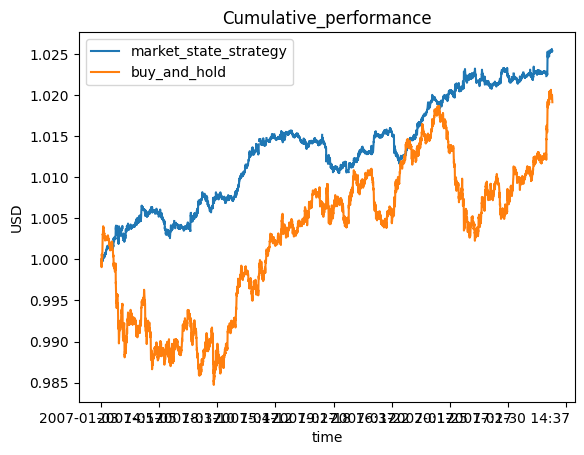

In [5]:
market_state_strategy(r)

# four months

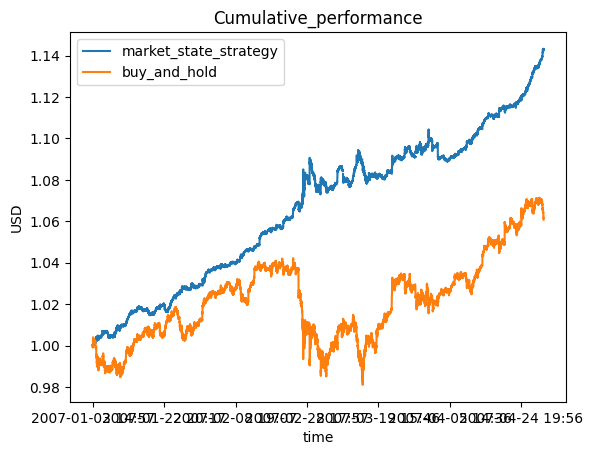

In [9]:
market_state_strategy(r)

## With FDR with $\alpha$=0.7

d:\Document\EPFL_Coursework\FinancialBigData\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Document\EPFL_Coursework\FinancialBigData\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Document\EPFL_Coursework\FinancialBigData\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Document\EPFL_Coursework\FinancialBigData\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Document\EPFL_Coursework\FinancialBigData\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Document\EPFL_Coursework\FinancialBigData\.v

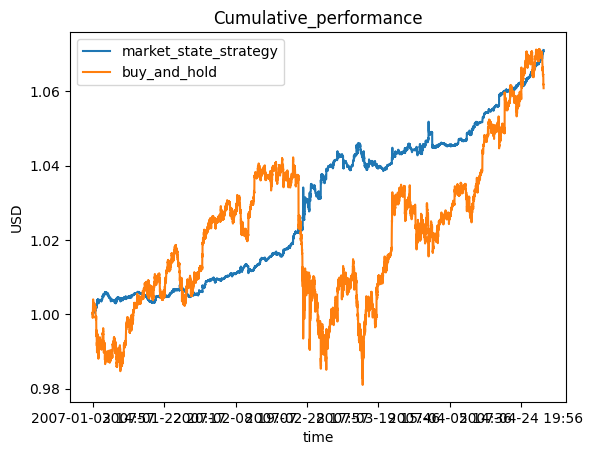

In [4]:
market_state_strategy(r)

# 2007

In [3]:
from upload_data import upload_clean_data
from market_state_strategy import market_state_strat_upgraded, strat_eval

filepath=r"D:\Document\EPFL_Coursework\FinancialBigData\clean\SP500_2007"
all_data=upload_clean_data(filepath)

In [4]:
all=all_data.set_index(['minute','ticker']).unstack(level='ticker')

non_null_counts = all.count()
selected_columns = non_null_counts[non_null_counts > 90000].index
all_filtered = all[selected_columns]
all_filtered.index = pd.to_datetime(all_filtered.index)
all_filtered.index = all_filtered.index + pd.Timedelta(minutes=1)

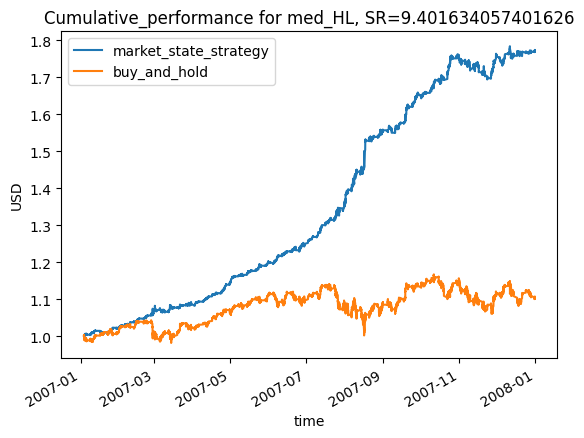

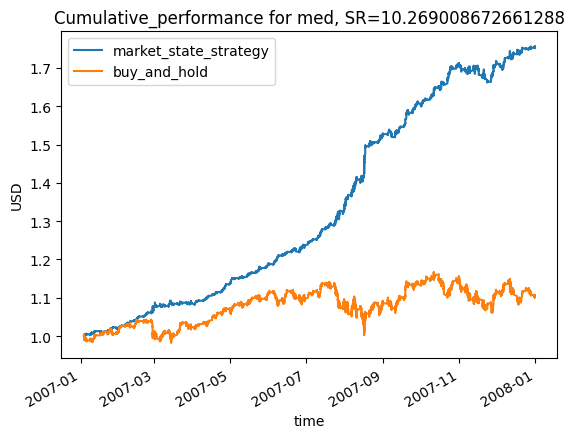

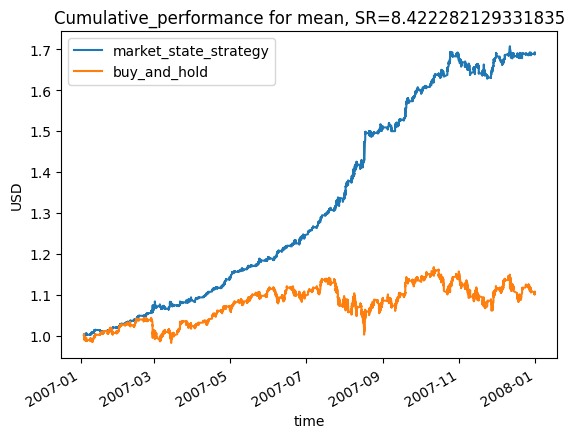

In [5]:
all_fill = all_filtered.ffill().bfill()
r=np.log(all_fill).diff()
Ms=['med_HL', 'med', 'mean']
for m in Ms:
    ret=market_state_strat_upgraded(r, trend_measure=m)
    strat_eval(ret, m)
    


In [11]:
all_fill = all_filtered.ffill()
r=np.log(all_fill).diff()

all_fill

vwap                                              \
ticker                    AA.N      ABT.N      AEP.N      AVP.N      AXP.N   
minute                                                                       
2007-01-03 14:31:00        NaN  48.833295        NaN  32.915633        NaN   
2007-01-03 14:32:00  29.886544  48.924805  42.493664  33.012088        NaN   
2007-01-03 14:33:00  29.902933  48.979192  42.512895  33.068729        NaN   
2007-01-03 14:34:00  29.950623  48.998300  42.605600  33.128783        NaN   
2007-01-03 14:35:00  29.979737  48.979465  42.672500  33.136750        NaN   
...                        ...        ...        ...        ...        ...   
2007-12-31 20:56:00  36.560981  56.155882  46.508000  39.630403  52.133406   
2007-12-31 20:57:00  36.574200  56.169824  46.529054  39.630339  52.145075   
2007-12-31 20:58:00  36.542786  56.118265  46.487333  39.629545  52.103602   
2007-12-31 20:59:00  36.542806  56.076479  46.490609  39.661659  52.090752   
2007-12-31 21:00:00  36.511310  56.076095  46.473997  39.626061  52.073105   

                                                                            \
ticker                    BA.N      BAC.N      BAX.N      BHI.N       BK.N   
minute                                                                       
2007-01-03 14:31:00  88.990662  53.296366  46.399533        NaN  39.680435   
2007-01-03 14:32:00  88.969032  53.318827  46.476087        NaN  39.789167   
2007-01-03 14:33:00  89.201183  53.340640  46.495968        NaN  39.948346   
2007-01-03 14:34:00  89.462869  53.402308  46.647692  73.626691  39.985649   
2007-01-03 14:35:00  89.332162  53.558971  46.694630  73.079487  39.970360   
...                        ...        ...        ...        ...        ...   
2007-12-31 20:56:00  87.423750  41.275030  58.022308  81.292982  48.770995   
2007-12-31 20:57:00  87.442086  41.252008  58.004516  81.282006  48.756696   
2007-12-31 20:58:00  87.446286  41.215212  57.977316  81.207566  48.750424   
2007-12-31 20:59:00  87.464878  41.183567  57.949514  81.191244  48.711164   
2007-12-31 21:00:00  87.437053  41.183871  57.953809  81.150139  48.683983   

                     ...                                              \
ticker               ...      USB.N      UTX.N       VZ.N      WAG.N   
minute               ...                                               
2007-01-03 14:31:00  ...  35.618661  62.607905        NaN  45.898943   
2007-01-03 14:32:00  ...  35.976306  62.950885        NaN  46.174609   
2007-01-03 14:33:00  ...  36.050842  62.945503        NaN  46.298085   
2007-01-03 14:34:00  ...  36.092998  62.979286        NaN  46.351843   
2007-01-03 14:35:00  ...  36.111881  62.974128  37.953035  46.299185   
...                  ...        ...        ...        ...        ...   
2007-12-31 20:56:00  ...  31.738466  76.533636  43.739960  38.120886   
2007-12-31 20:57:00  ...  31.743791  76.575612  43.740696  38.106497   
2007-12-31 20:58:00  ...  31.712425  76.506640  43.715757  38.062545   
2007-12-31 20:59:00  ...  31.690198  76.480420  43.704105  38.051339   
2007-12-31 21:00:00  ...  31.694291  76.482465  43.679124  38.061487   

                                                                            \
ticker                   WFC.N      WMB.N      WMT.N       WY.N      XOM.N   
minute                                                                       
2007-01-03 14:31:00        NaN        NaN  47.100020        NaN        NaN   
2007-01-03 14:32:00        NaN        NaN  47.132193        NaN        NaN   
2007-01-03 14:33:00        NaN  25.999167  47.158139  71.058492  75.669337   
2007-01-03 14:34:00        NaN  25.889940  47.265910  71.283016  75.703973   
2007-01-03 14:35:00        NaN  25.767747  47.399939  71.465120  75.514586   
...                        ...        ...        ...        ...        ...   
2007-12-31 20:56:00  30.246521  35.781935  47.503070  73.610392  93.784171   
2007-12-31 20:57:00  30.236259  35.774172  47.51215

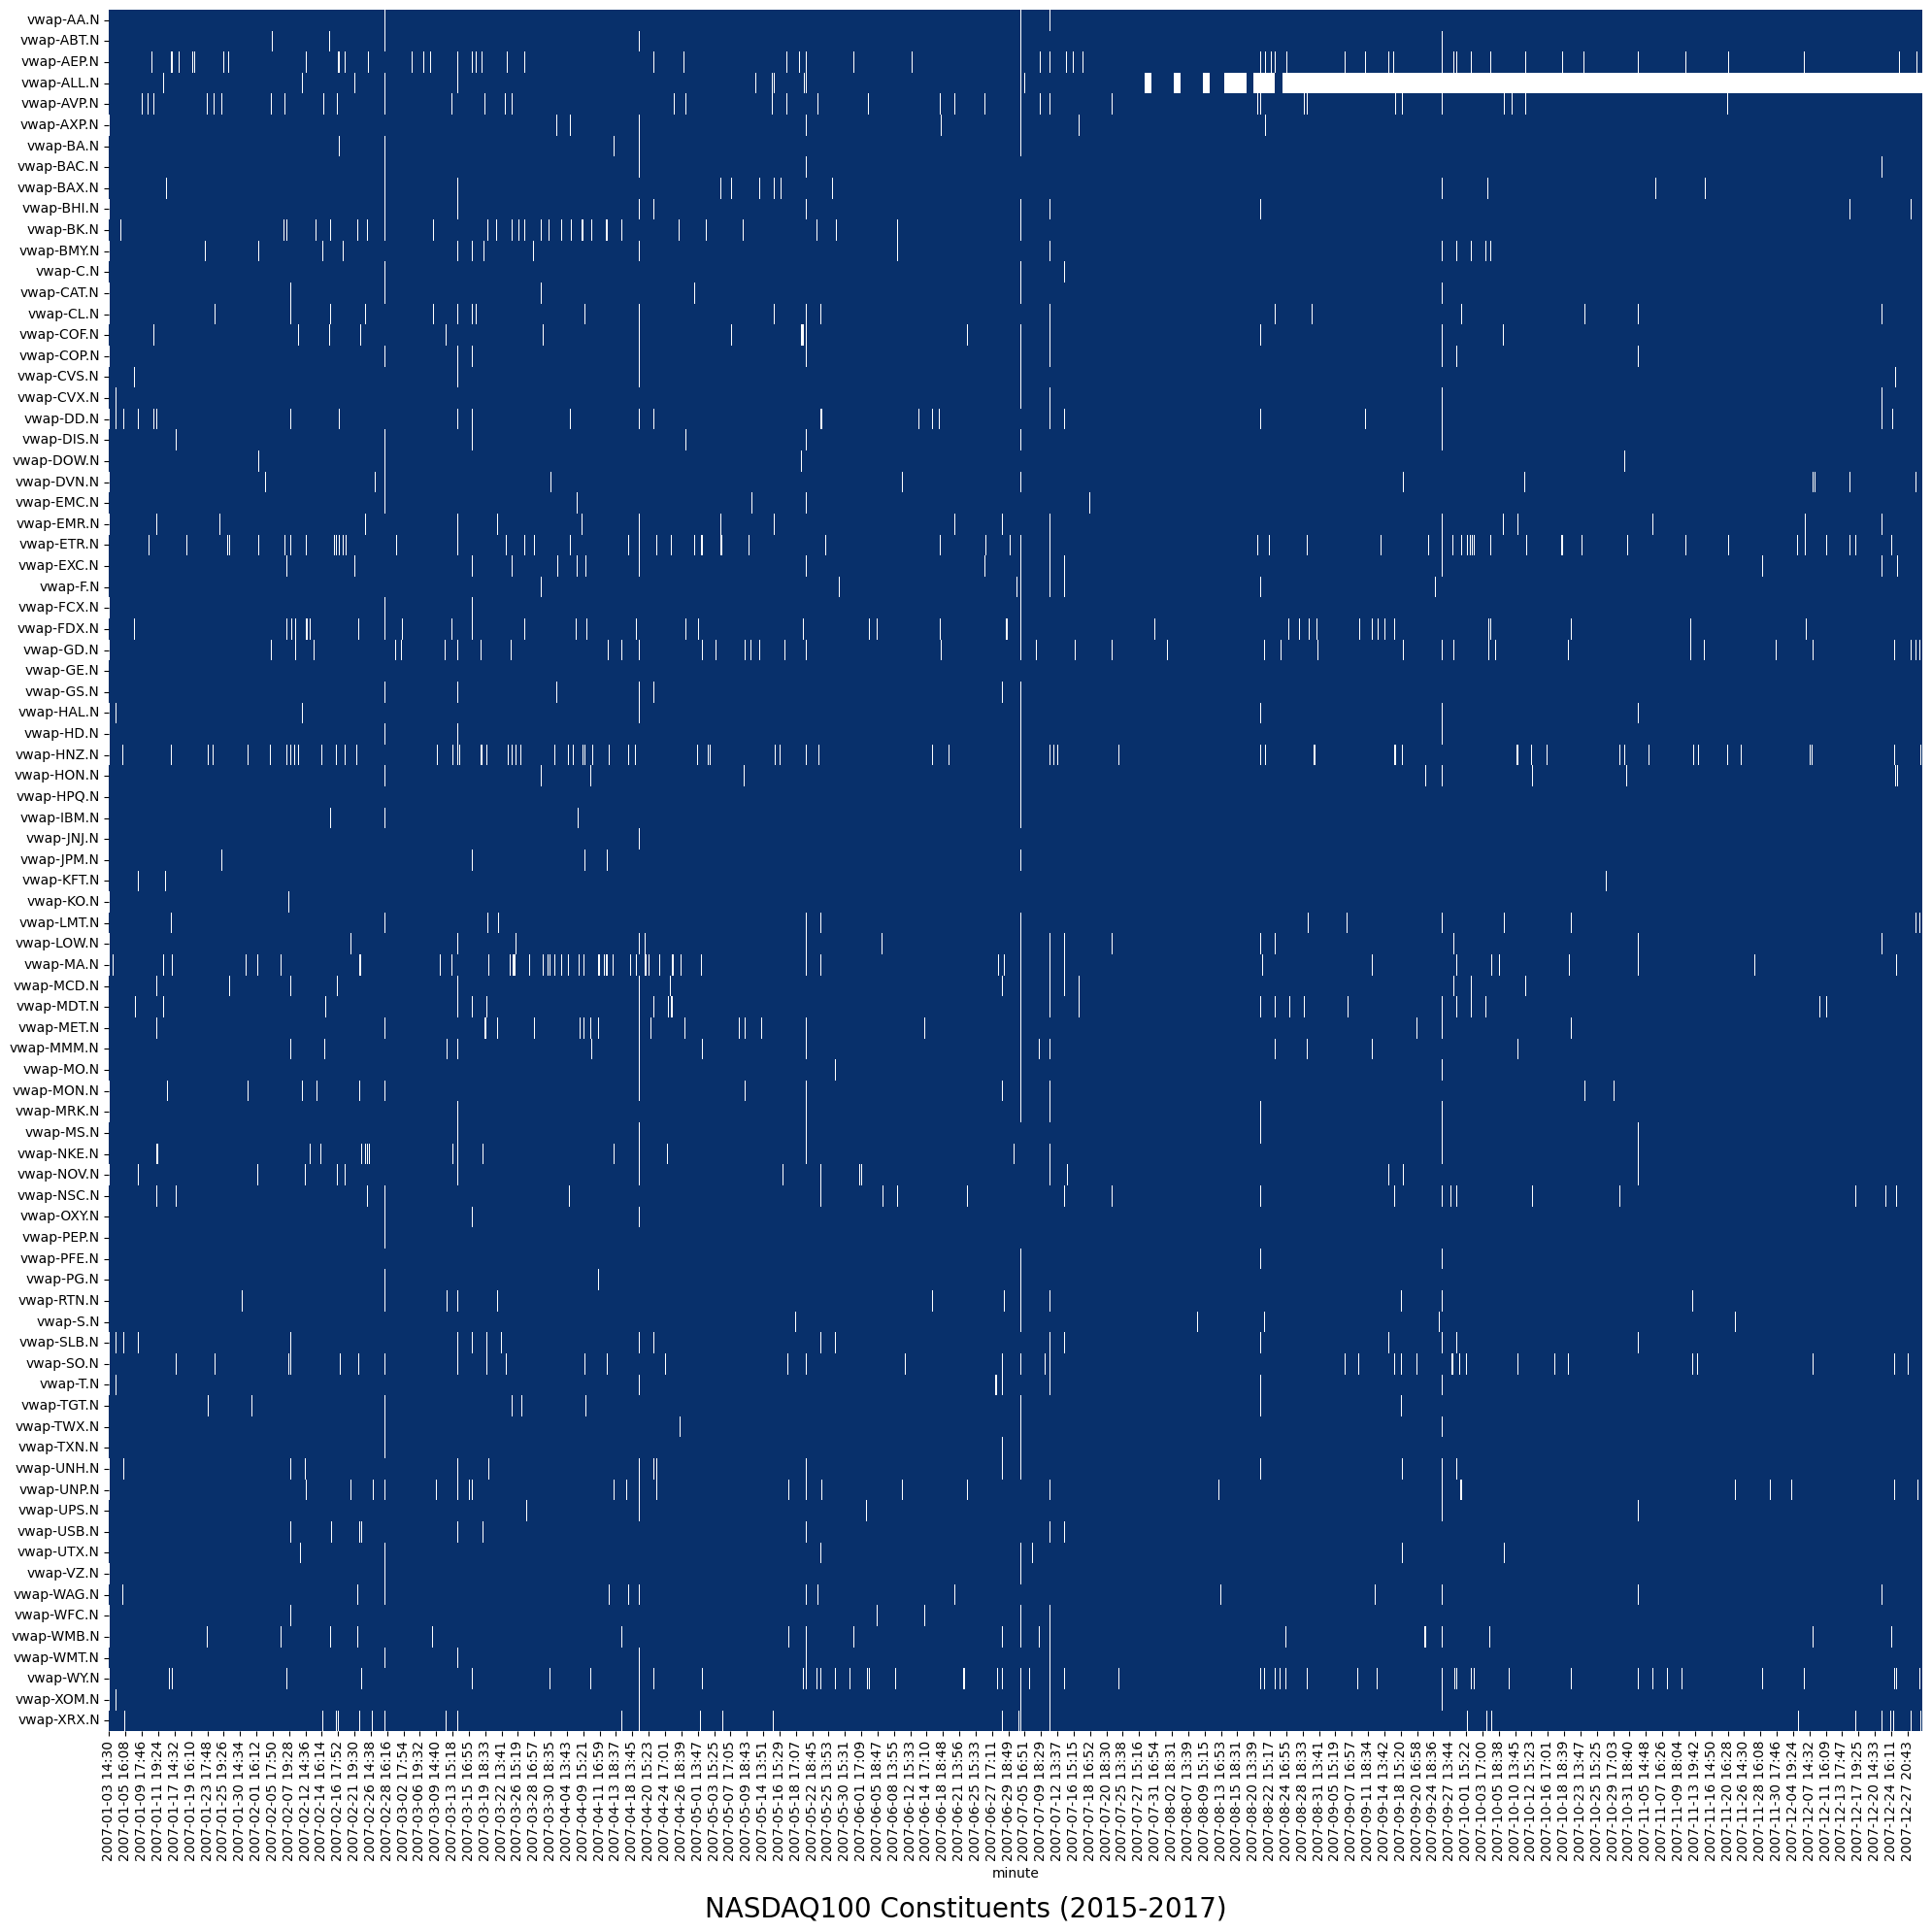

In [12]:
import seaborn as sns
nonnull_stock_filter = (all.notnull().astype(int).replace(0, np.nan))
fig, ax = plt.subplots(figsize=(20, 20))
mask = nonnull_stock_filter.T.isnull()
ax = sns.heatmap(nonnull_stock_filter.T, mask=mask, cbar=False, ax=ax, cmap='Blues_r')
ax.set_ylabel('', fontsize = 15)
fig.suptitle('NASDAQ100 Constituents (2015-2017)',y = 0, fontsize = 20)
fig.tight_layout()
#plt.savefig('Nasdaq_const.pdf',bbox_inches='tight', dpi = 1000)
plt.show()

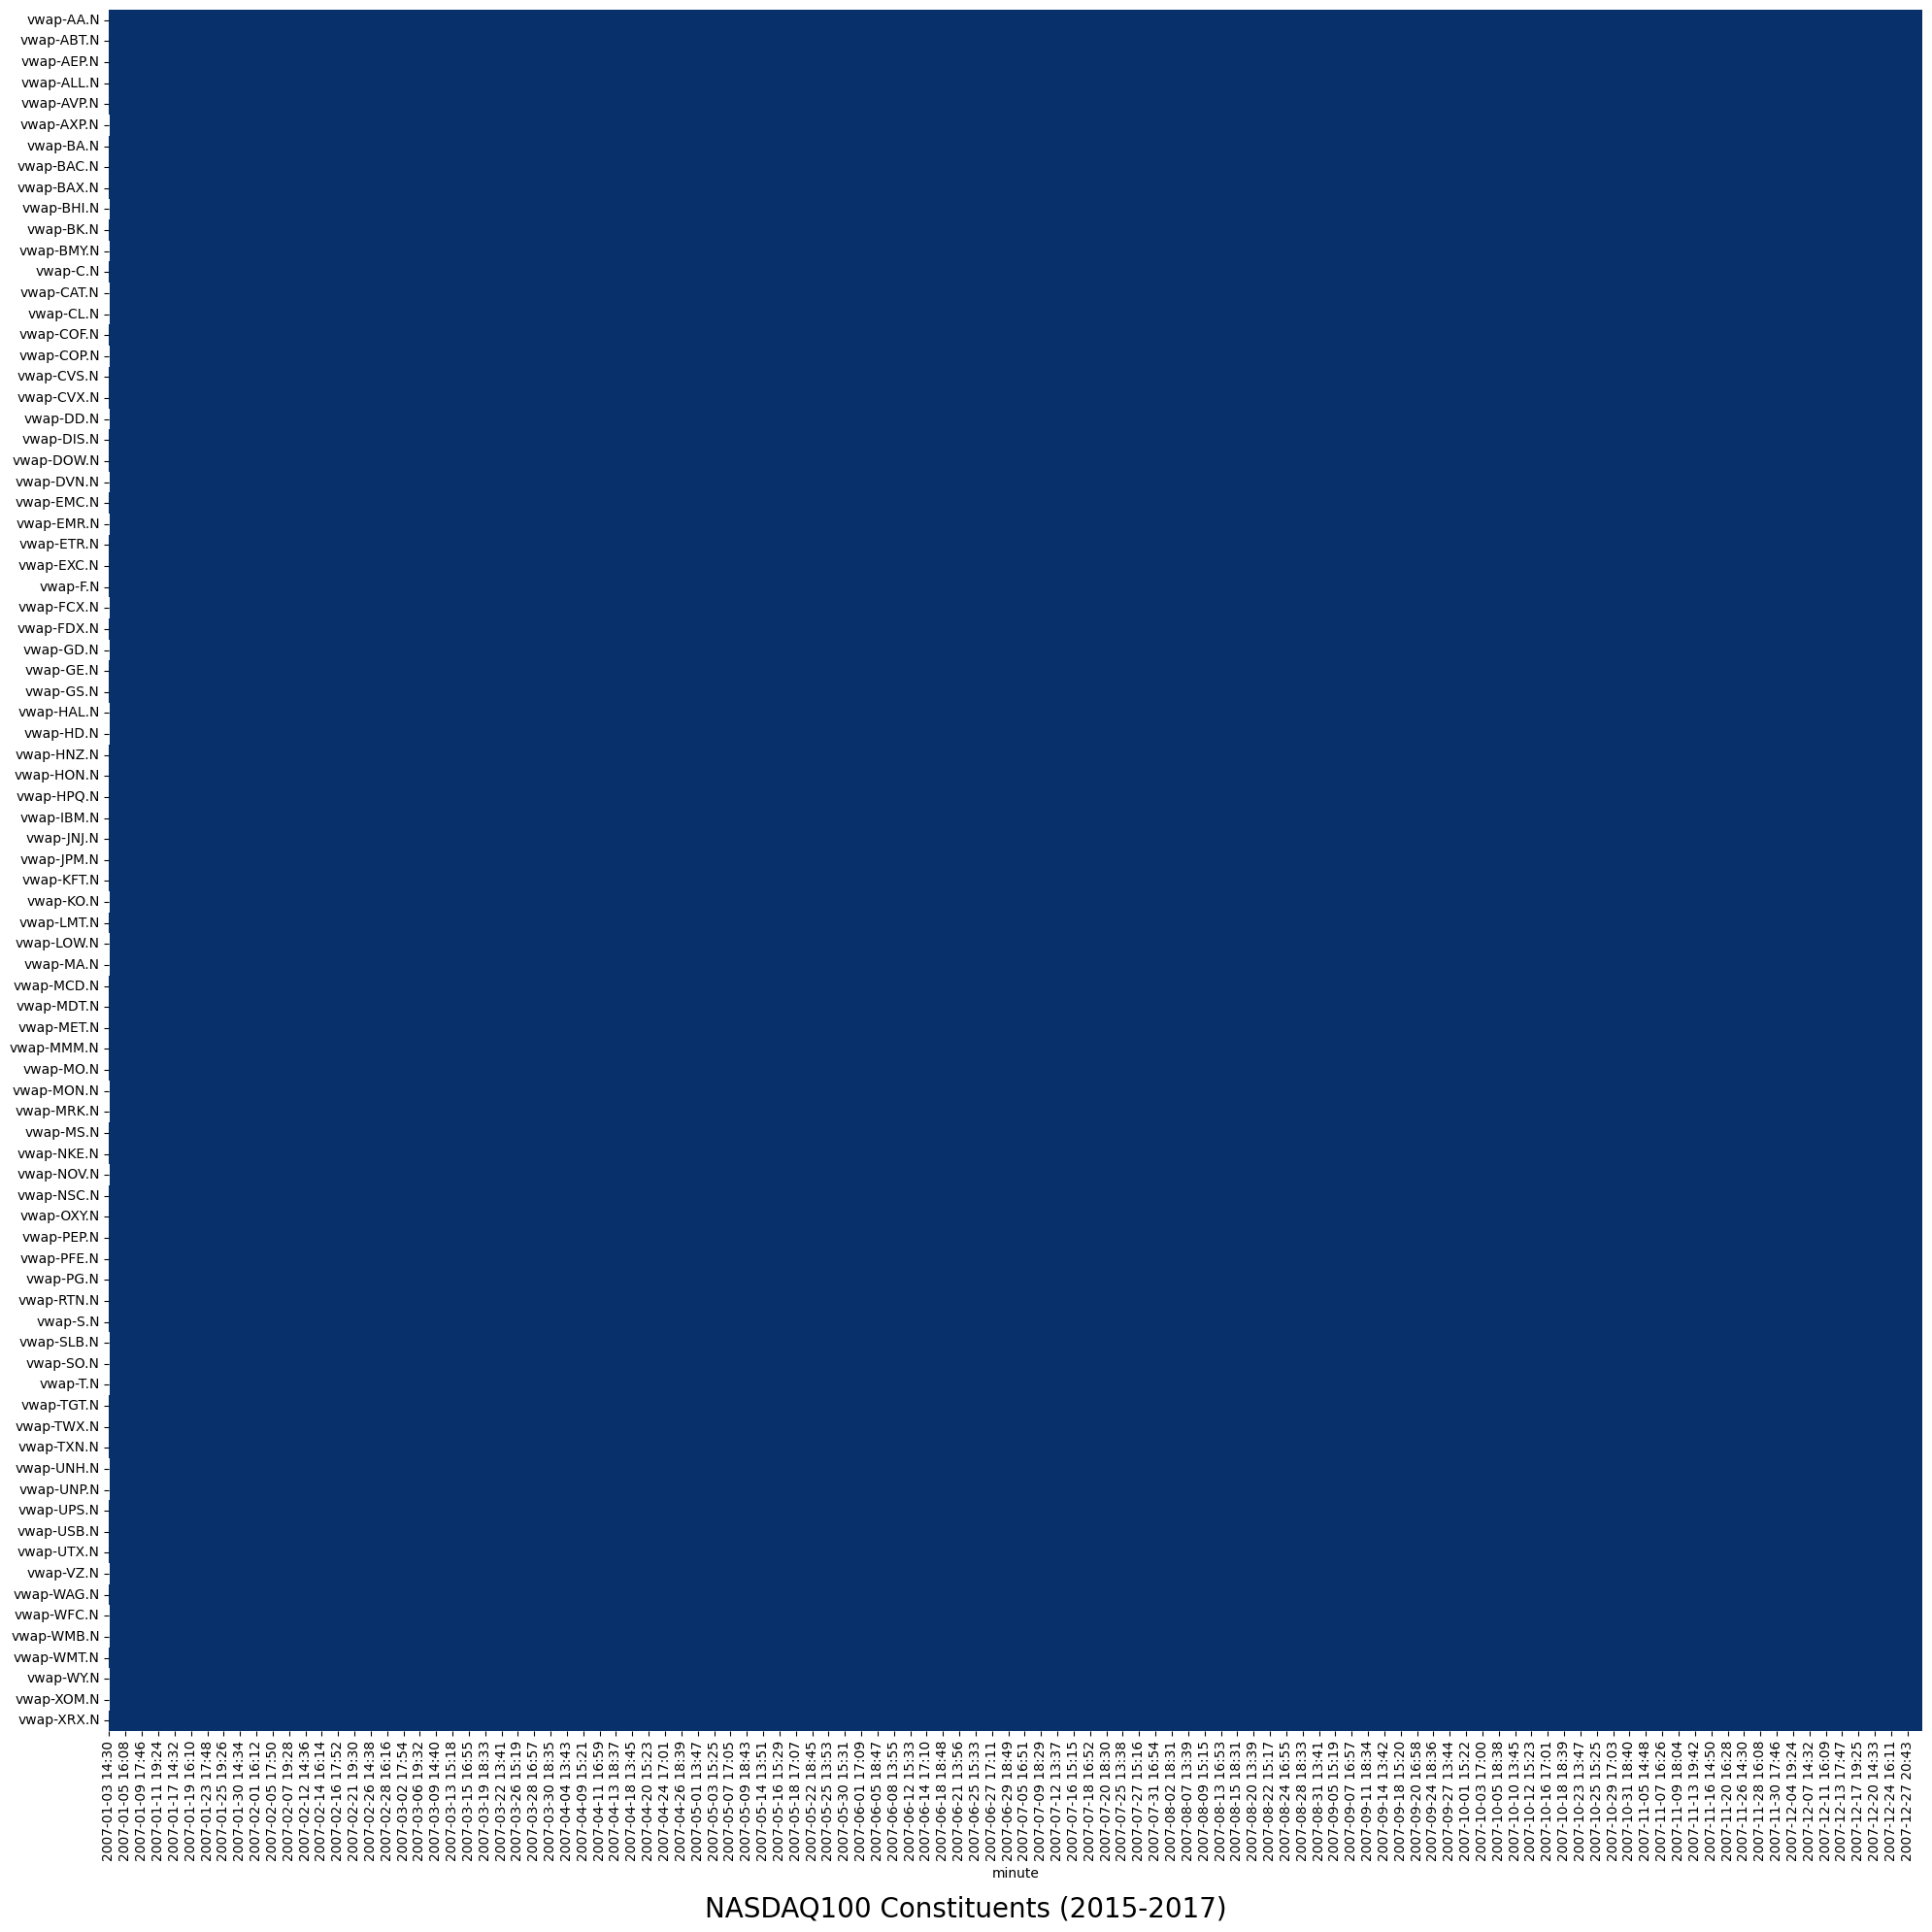

In [13]:
nonnull_stock_filter = (all.ffill().notnull().astype(int).replace(0, np.nan))
fig, ax = plt.subplots(figsize=(20, 20))
mask = nonnull_stock_filter.T.isnull()
ax = sns.heatmap(nonnull_stock_filter.T, mask=mask, cbar=False, ax=ax, cmap='Blues_r')
ax.set_ylabel('', fontsize = 15)
fig.suptitle('NASDAQ100 Constituents (2015-2017)',y = 0, fontsize = 20)
fig.tight_layout()
#plt.savefig('Nasdaq_const.pdf',bbox_inches='tight', dpi = 1000)
plt.show()

## add portfolio optimzation

In [82]:
from numpy import linalg as LA
from bahc import filterCovariance
from market_state_strategy import med_HL
def eigenvalue_clipping(lambdas,v,lambda_plus):
    N=len(lambdas)

    # _s stands for _structure below
    sum_lambdas_gt_lambda_plus=np.sum(lambdas[lambdas>lambda_plus])
    
    sel_bulk=lambdas<=lambda_plus                     # these eigenvalues come from the seemingly random bulk
    N_bulk=np.sum(sel_bulk)
    sum_lambda_bulk=np.sum(lambdas[sel_bulk])        
    delta=sum_lambda_bulk/N_bulk                      # delta is their average, so as to conserver the trace of C
    
    lambdas_clean=lambdas
    lambdas_clean[lambdas_clean<=lambda_plus]=delta
    
    
    C_clean=np.zeros((N, N))
    v_m=np.matrix(v)
    
    for i in range(N-1):
        C_clean=C_clean+lambdas_clean[i] * np.dot(v_m[i,].T,v_m[i,]) 
        
    np.fill_diagonal(C_clean,1)
            
    return C_clean    
    
def Corr_clip(R):
    T, N =R.shape
    C=R.corr()
    l_e, V_e = LA.eig(C)
    # N = C.shape[0]
    q = N/T
    lambda_plus = (1+np.sqrt(q))**2
    C_clipped=eigenvalue_clipping(l_e,V_e,lambda_plus)
    return C_clipped

def _cal_w(R, e, is_BAHC): # T by N
    if is_BAHC:
        x=R.T
        C=filterCovariance(x.values, is_correlation=False)   
    else:
        C=R.cov()
    inv_cov = np.linalg.pinv(C)
    min_var_weights = (inv_cov @ e) / np.dot( e, inv_cov @ e)
    return min_var_weights

def number_of_states(r):
    Num=[]
    T=int(np.floor(r.shape[1]/3))
    for t in range(T,r.shape[0]-1):
        R = r.iloc[t-T+1:t+1]
        DF = LouvainCorrelationClustering(R.T)
        Num.append(DF['Column_A'].nunique())
    return Num

def market_state_strat_upgraded(r, opt=False, is_BAHC=False, trend_measure='med', seed=10): #matrix of log returns
    np.random.seed(seed)
    T=int(np.floor(r.shape[1]/3))
    pos = pd.DataFrame(0.0, index=r.index, columns=r.columns)
    for t in range(T,r.shape[0]-1):
        R = r.iloc[t-T+1:t+1]
        DF = LouvainCorrelationClustering(R.T)
        cur_state=DF.iloc[-1][0]
        I = DF[DF[0]==cur_state].index.tolist()
        my_list = [x+1 for x in I[:-1]]
        if my_list:
            if trend_measure=='med_HL':
                ar=med_HL(R.iloc[my_list])
            elif trend_measure=='med':
                ar=R.iloc[my_list].median(axis=0)
            else:
                ar=R.iloc[my_list].mean(axis=0)
            e = np.sign(ar.values)
            if opt:
                w=_cal_w(R, e, is_BAHC)
            else:
                w = e/r.shape[1]
            pos.iloc[t+1] = w
    return pos #all_ret

def strat_eval(pos, r, Strat_Name):
    #robust sharp ratio
    # start = max([r.index[0], pos.index[0]])
    # end = min([r.index[-1], pos.index[-1]])
    # r = r.loc[start:end,]
    T=int(np.floor(r.shape[1]/3))
    model_returns=pos.iloc[T:]*r.iloc[T:]
    total_returns=model_returns.sum(axis=1)
    cum_perf=total_returns+1
    cum_return=cum_perf.cumprod()-1
    # all_ret=pd.DataFrame({'Strat_A':ret}, index=r.index[T:])
    # all_ret['BH']=np.concatenate(([0], np.dot(np.exp(r.iloc[T+1:])-1, np.ones(len(pos)))/len(pos)))
    # all_ret['Strat_A_perf']=all_ret['Strat_A']+1.0
    # all_ret['BH_perf']=all_ret['BH']+1.0
    cum_return.plot(label=Strat_Name)
    # all_ret['BH_perf'].cumprod().plot(label='buy_and_hold')
    # sharpe_ratio=_calc_sharpe(all_ret['Strat_A'])
    # return model_returns
    return cum_return

#2007-2008

In [7]:
filepath=r"D:\Document\EPFL_Coursework\FinancialBigData\clean\2007-2008-vwap-trade-1min.parquet"
all=pd.read_parquet(filepath)

# all.set_index('index', inplace=True)
all.replace(0, np.nan, inplace=True)
# all=all_data.set_index(['minute','ticker']).unstack(level='ticker')
non_null_counts = all.count()
selected_columns = non_null_counts[non_null_counts > 90000].index
all_filtered = all[selected_columns]
all_filtered.index = pd.to_datetime(all_filtered.index)
all_filtered.index = all_filtered.index + pd.Timedelta(minutes=1)
all_fill = all_filtered.ffill()

lin_ret78=all_fill.pct_change()
rows_with_null = lin_ret78[lin_ret78.isnull().any(axis=1)]
lin_ret78 = lin_ret78.loc[rows_with_null.index[-1]:]


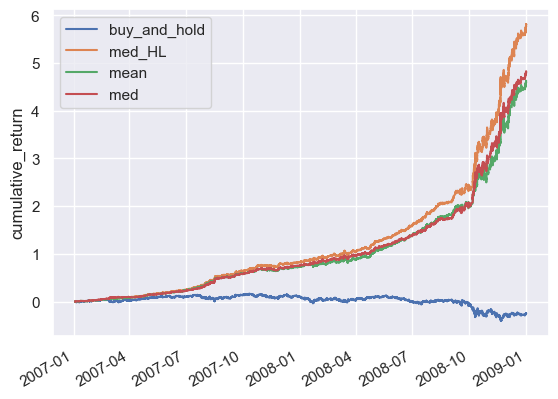

In [12]:
import seaborn as sns
sns.set()

r=lin_ret78.copy()
# r=lin_ret78.iloc[:100]
T=int(np.floor(r.shape[1]/3))
M=['med_HL', 'mean', 'med']

# buy and hold
pos= pd.DataFrame(0.0, index=r.index, columns=r.columns)
pos.iloc[T+1:]=1/r.shape[1]
cr=strat_eval(pos, r, Strat_Name='buy_and_hold')

# market state strategy
pos_list=[pos]
for m in M:
    pos=market_state_strat_upgraded(r, opt=False, is_BAHC=False, trend_measure=m)
    pos_list.append(pos)
    _=strat_eval(pos, r, Strat_Name=m)

# for m in M:
#     pos=market_state_strat_upgraded(r, opt=True, is_BAHC=False, trend_measure=m)
#     strat_eval(pos, r, Strat_Name=m+'_MPV_no_filter')

# for m in M:
#     pos=market_state_strat_upgraded(r, opt=True, is_BAHC=True, trend_measure=m)
#     strat_eval(pos, r, Strat_Name=m+'_MPV_BAHC')

plt.xlabel('')
plt.ylabel('cumulative_return')
plt.legend()
plt.show()


# 2007 linear ret

In [6]:
all_fill = all_filtered.ffill()
# log_ret=np.log(all_fill).diff()
rows_with_null = all_fill[all_fill.isnull().any(axis=1)]
all_fill = all_fill.loc[rows_with_null.index[-1]+1:]
lin_ret=all_fill.pct_change()

lin_ret.loc['2007-01-04']

vwap                                          \
ticker                   AA.N     ABT.N     AEP.N     AVP.N     AXP.N   
minute                                                                  
2007-01-04 14:31:00  0.002703  0.000885  0.000000  0.000000  0.000000   
2007-01-04 14:32:00 -0.001919  0.004371  0.000000 -0.000430  0.000000   
2007-01-04 14:33:00 -0.000345 -0.000052  0.000000  0.000350  0.000000   
2007-01-04 14:34:00 -0.001670 -0.002560 -0.001170  0.000000  0.000000   
2007-01-04 14:35:00  0.000663  0.000012  0.000377  0.000000  0.000000   
...                       ...       ...       ...       ...       ...   
2007-01-04 20:56:00  0.000192 -0.000200 -0.000149  0.000226  0.000062   
2007-01-04 20:57:00 -0.000226  0.000575 -0.000193  0.000852 -0.000280   
2007-01-04 20:58:00  0.000102 -0.000786 -0.000014 -0.000379 -0.000614   
2007-01-04 20:59:00 -0.000336  0.000047  0.000085 -0.000502  0.000563   
2007-01-04 21:00:00 -0.000437 -0.000415 -0.000303 -0.000240 -0.000144   

                                                                       ...  \
ticker                   BA.N     BAC.N     BAX.N     BHI.N      BK.N  ...   
minute                                                                 ...   
2007-01-04 14:31:00  0.000000  0.000191  0.000035 -0.005196  0.000000  ...   
2007-01-04 14:32:00  0.000000  0.001304 -0.000491  0.001508  0.000097  ...   
2007-01-04 14:33:00  0.000000  0.000090  0.000492 -0.002384 -0.001748  ...   
2007-01-04 14:34:00 -0.000378 -0.002326  0.001173 -0.002534 -0.003959  ...   
2007-01-04 14:35:00  0.000378 -0.000530  0.001197 -0.000832 -0.001238  ...   
...                       ...       ...       ...       ...       ...  ...   
2007-01-04 20:56:00 -0.000020 -0.000231  0.000014  0.000364 -0.000459  ...   
2007-01-04 20:57:00 -0.000584 -0.000304  0.000319 -0.000116  0.000233  ...   
2007-01-04 20:58:00 -0.000295 -0.000337 -0.000299 -0.000377 -0.000797  ...   
2007-01-04 20:59:00  0.000300  0.000237 -0.001165 -0.000641  0.000657  ...   
2007-01-04 21:00:00  0.000180 -0.000098 -0.000292 -0.000670 -0.000355  ...   

                                                                       \
ticker                  USB.N     UTX.N      VZ.N     WAG.N     WFC.N   
minute                                                                  
2007-01-04 14:31:00  0.000641 -0.002655  0.000000 -0.005116 -0.001235   
2007-01-04 14:32:00 -0.000490  0.003368  0.005977  0.002166  0.004504   
2007-01-04 14:33:00 -0.001280 -0.000408 -0.000196 -0.001068  0.000668   
2007-01-04 14:34:00 -0.001214 -0.000900  0.000227 -0.000657 -0.005608   
2007-01-04 14:35:00 -0.001721 -0.000825  0.000160  0.000205 -0.001657   
...                       ...       ...       ...       ...       ...   
2007-01-04 20:56:00  0.000075 -0.000241  0.000218  0.000002 -0.000816   
2007-01-04 20:57:00 -0.000140 -0.000072 -0.000212  0.000313  0.000053   
2007-01-04 20:58:00  0.000093 -0.000176  0.000175 -0.000033 -0.000070   
2007-01-04 20:59:00 -0.000032  0.000546  0.000049 -0.000055 -0.000081   
2007-01-04 21:00:00 -0.000179  0.000230 -0.000036 -0.000008  0.000028   

                                                                       
ticker                  WMB.N     WMT.N      WY.N     XOM.N     XRX.N  
minute                                                                 
2007-01-04 14:31:00  0.000283  0.000691  0.000000  0.000000  0.000582  
2007-01-04 14:32:00 -0.001412 -0.000768  0.000000  0.000000 -0.001891  
2007-01-04 14:33:00  0.002293 -0.000809 -0.004485 -0.008446 -0.001967  
2007-01-04 14:34:00 -0.002721 -0.001448 -0.001805 -0.001379 -0.002440  
2007-01-04 14:35:00 -0.000956 -0.000901 -0.000595 -0.001716 -0.000718  
...                       ...       ...       ...       ...       ...  
2007-01-04 20:56:00 -0.001115 -0.000290 -0.000187  0.000571 -0.000266  
2007-01-04 20:57:00 -0.001354 -0.000557 -0.000173  0.000538  0.000148  
2007-01-04 20:58:00 -0.000290 -0.000228 -0.000015 -0.000337 -0.000217  
2007-01-04 20:59:00  0

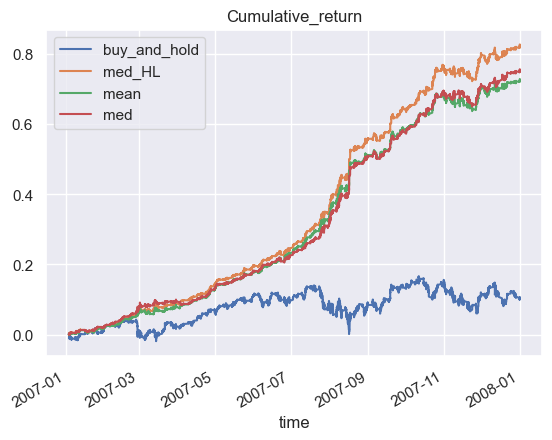

In [15]:
import seaborn as sns
sns.set()

r=lin_ret.copy()
# r=lin_ret.iloc[:100]
T=int(np.floor(r.shape[1]/3))
M=['med_HL', 'mean', 'med']

# buy and hold
pos= pd.DataFrame(0.0, index=r.index, columns=r.columns)
pos.iloc[T+1:]=1/r.shape[1]
mr=strat_eval(pos, r, Strat_Name='buy_and_hold')

# market state strategy
pos_list=[pos]
for m in M:
    pos=market_state_strat_upgraded(r, opt=False, is_BAHC=False, trend_measure=m)
    pos_list.append(pos)
    strat_eval(pos, r, Strat_Name=m)

# for m in M:
#     pos=market_state_strat_upgraded(r, opt=True, is_BAHC=False, trend_measure=m)
#     strat_eval(pos, r, Strat_Name=m+'_MPV_no_filter')

# for m in M:
#     pos=market_state_strat_upgraded(r, opt=True, is_BAHC=True, trend_measure=m)
#     strat_eval(pos, r, Strat_Name=m+'_MPV_BAHC')

plt.xlabel('')
plt.ylabel('cumulative_return')
# plt.title(f'Cumulative_return')
plt.legend()
plt.show()

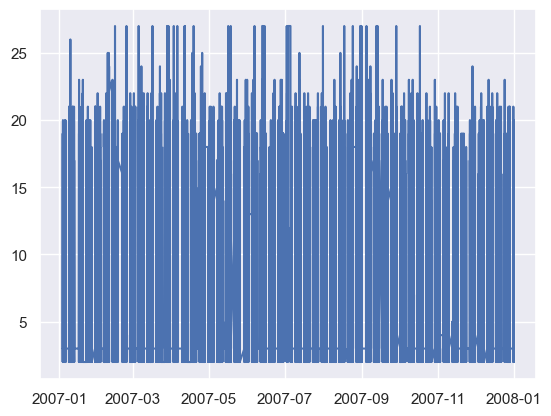

In [19]:
def number_of_states(r):
    Num=[]
    T=int(np.floor(r.shape[1]/3))
    for t in range(T,r.shape[0]-1):
        R = r.iloc[t-T+1:t+1]
        DF = LouvainCorrelationClustering(R.T)
        Num.append(DF[0].nunique())
    return Num

Num=number_of_states(r)
plt.plot(r.iloc[T:r.shape[0]-1].index,Num)

Text(0, 0.5, 'Number of Market states')

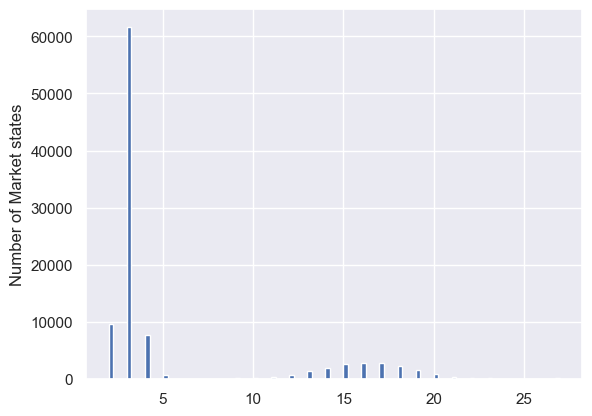

In [53]:
k=[num for num in Num if num > 22]
plt.hist(Num, bins=100)
plt.ylabel('Number of Market states')

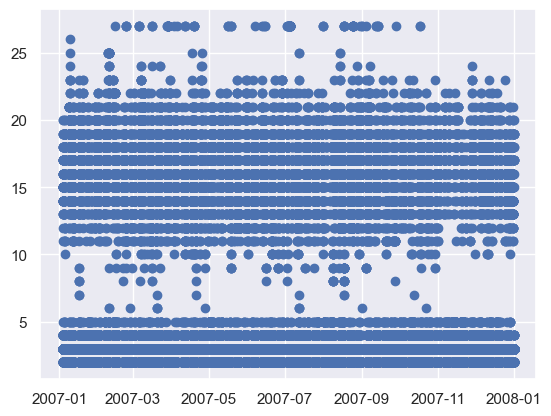

In [37]:
plt.scatter(r.iloc[T:r.shape[0]-1].index,Num, marker='o')

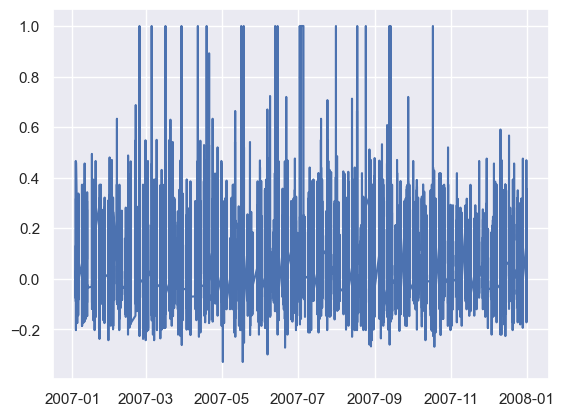

In [41]:
#ARI
from sklearn.metrics import adjusted_rand_score
ari=[]
T=int(np.floor(r.shape[1]/3))    
for t in range(T,r.shape[0]-2): 
    R1 = r.iloc[t-T+1:t+1]
    R2 = r.iloc[t-T+2:t+2]
    DF1 = LouvainCorrelationClustering(R1.T)
    DF2 = LouvainCorrelationClustering(R2.T)
    ari.append(adjusted_rand_score(DF1[0], DF2[0]))




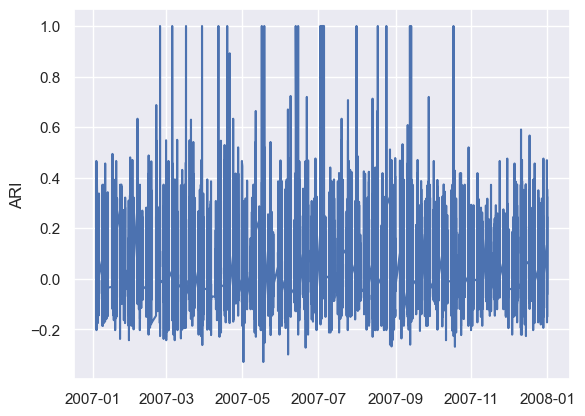

In [50]:
plt.plot(r.iloc[T:r.shape[0]-2].index,ari)
plt.ylabel('ARI')


plt.show()

Text(0.5, 0, 'ARI')

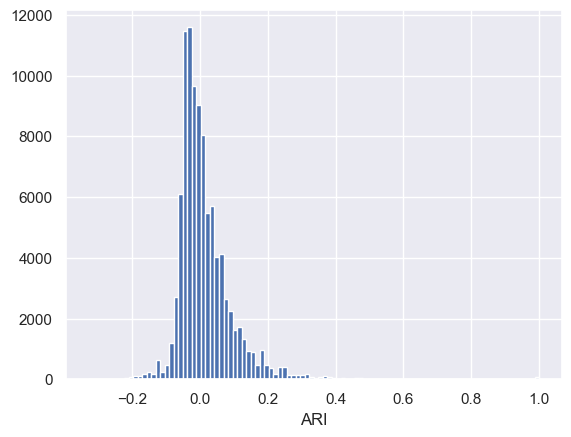

In [51]:

plt.hist(ari, bins=100)
plt.xlabel('ARI')

# 2010

In [84]:
filepath=r"D:\Document\EPFL_Coursework\FinancialBigData\clean\SP500-2010.parquet"
all=pd.read_parquet(filepath)

In [85]:
# filepath=r"D:\Document\EPFL_Coursework\FinancialBigData\clean\SP500-2010.parquet"
# all_data=upload_clean_data(filepath)
all.set_index('index', inplace=True)
all.replace(0, np.nan, inplace=True)
# all=all_data.set_index(['minute','ticker']).unstack(level='ticker')
non_null_counts = all.count()
selected_columns = non_null_counts[non_null_counts > 90000].index
all_filtered = all[selected_columns]
# all_filtered.index = pd.to_datetime(all_filtered.index)
# all_filtered.index = all_filtered.index + pd.Timedelta(minutes=1)
all_fill = all_filtered.ffill()

# rows_with_null = all_fill[all_fill.isnull().any(axis=1)]
# all_fill = all_fill.loc[rows_with_null.index[-1]+1:]
lin_ret2010=all_fill.pct_change()
# rows_with_null = lin_ret2010[lin_ret2010.isnull().any(axis=1)]
# lin_ret2010 = lin_ret2010.loc[rows_with_null.index[-1]:]
# Drastic_columns=['ACN', 'CNP', 'HAS', 'PDP']_
max_values_per_column=lin_ret2010.max(axis=0)
columns_greater_than_1 = max_values_per_column[max_values_per_column > 1].index
lin_ret2010 = lin_ret2010.drop(columns=columns_greater_than_1)


In [86]:
import seaborn as sns
sns.set()

# max_values_per_column=lin_ret2010.max(axis=0)
# columns_greater_than_1 = max_values_per_column[max_values_per_column > 80].index
# lin_ret2010 = lin_ret2010.drop(columns=columns_greater_than_1)

r=lin_ret2010.copy()
# r=lin_ret.iloc[:100]
T=int(np.floor(r.shape[1]/3))
M=['med_HL', 'mean', 'med']

# buy and hold
pos= pd.DataFrame(0.0, index=r.index, columns=r.columns)
pos.iloc[T+1:]=1/r.shape[1]
cr=strat_eval(pos, r, Strat_Name='buy_and_hold')


# market state strategy
pos_list=[pos]
for m in M:
    pos=market_state_strat_upgraded(r, opt=False, is_BAHC=False, trend_measure=m)
    pos_list.append(pos)
    _=strat_eval(pos, r, Strat_Name=m)

# for m in M:
#     pos=market_state_strat_upgraded(r, opt=True, is_BAHC=False, trend_measure=m)
#     strat_eval(pos, r, Strat_Name=m+'_MPV_no_filter')

# for m in M:
#     pos=market_state_strat_upgraded(r, opt=True, is_BAHC=True, trend_measure=m)
#     strat_eval(pos, r, Strat_Name=m+'_MPV_BAHC')

plt.xlabel('')
plt.ylabel('cumulative_return')
plt.legend()
plt.show()

# cr

In [79]:
max_values_per_column=lin_ret2010.max(axis=0)
columns_greater_than_1 = max_values_per_column[max_values_per_column > 1].index

# max_values_per_column[columns_greater_than_1]
columns_greater_than_1
# lin_ret2010.loc['2010-05-06',columns_greater_than_1].plot()


Index([], dtype='object')

In [68]:
all_fill.loc['2010-05-06 18',columns_greater_than_1].min(axis=0)

ACN     0.0100
CNP     0.0135
HAS    36.3300
PDP     0.1000
dtype: float64

In [74]:
A=all_fill.loc['2010-05-06 18',columns_greater_than_1]

B=lin_ret2010.loc['2010-05-06 18',columns_greater_than_1]+1

C=B.cumprod()


<Axes: xlabel='index'>

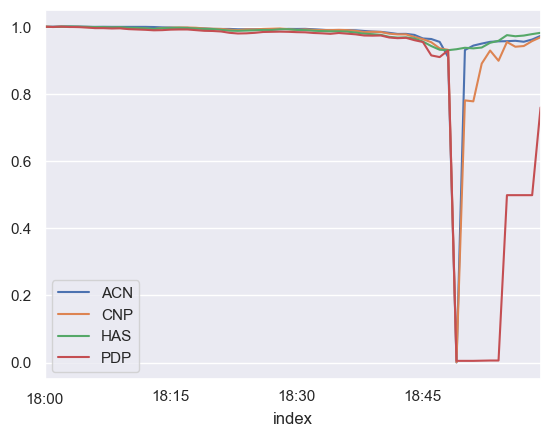

In [76]:
C.plot()

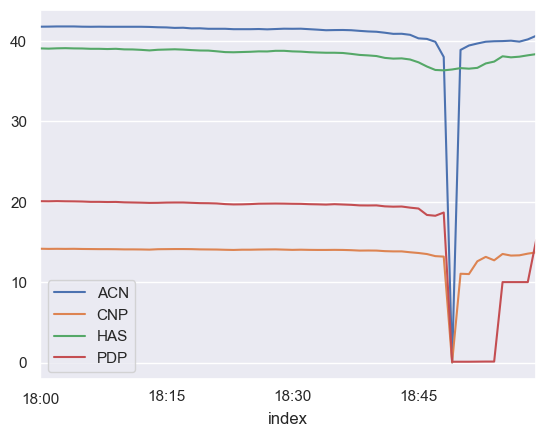

In [70]:
all_fill.loc['2010-05-06 18',columns_greater_than_1].plot()

# RE of robust statistics

In [40]:
import numpy as np
import matplotlib.pyplot as plt

from market_state_strategy import med_HL 

N = 1000
RE1 = []
RE2=[]
ub=20
for v in range(2,ub):
    t_distribution_data = np.random.standard_t(v, size=[N,100])
    df=pd.DataFrame(t_distribution_data)
    column_means = np.mean(t_distribution_data, axis=0)
    column_medians = np.median(t_distribution_data, axis=0)
    column_medHL=med_HL(df)
    RE1.append(np.mean((column_medians - np.mean(column_medians))**2)/np.mean((column_means - np.mean(column_means))**2)) 
    RE2.append(np.mean((column_medHL - np.mean(column_medHL))**2)/np.mean((column_means - np.mean(column_means))**2))

plt.plot(range(2,ub), RE1, label='RE_med')
plt.plot(range(2,ub), RE2, label='RE_medHL')

# plt.title(f'')
plt.xlabel('v')
plt.ylabel('RE')
plt.legend()
plt.show()


KeyboardInterrupt: 

# bid ask 

In [ ]:
def market_state_strat_upgraded(r, opt=False, is_BAHC=False, trend_measure='med', seed=10): #matrix of log returns
    np.random.seed(seed)
    T=int(np.floor(r.shape[1]/3))
    pos = pd.DataFrame(0.0, index=r.index, columns=r.columns)
    for t in range(T,r.shape[0]-1):
        R = r.iloc[t-T+1:t+1]
        DF = LouvainCorrelationClustering(R.T)
        cur_state=DF.iloc[-1][0]
        I = DF[DF[0]==cur_state].index.tolist()
        my_list = [x+1 for x in I[:-1]]
        if my_list:
            if trend_measure=='med_HL':
                ar=med_HL(R.iloc[my_list])
            elif trend_measure=='med':
                ar=R.iloc[my_list].median(axis=0)
            else:
                ar=R.iloc[my_list].mean(axis=0)
            e = np.sign(ar.values)
            if opt:
                w=_cal_w(R, e, is_BAHC)
            else:
                w = e/r.shape[1]
            pos.iloc[t+1] = w
    return pos #all_ret

def strat_eval_bbo(pos, r_bid, r_ask, Strat_Name):
    #robust sharp ratio
    # start = max([r.index[0], pos.index[0]])
    # end = min([r.index[-1], pos.index[-1]])
    # r = r.loc[start:end,]
    T=int(np.floor(r.shape[1]/3))
    df=pos.iloc[T:]
    buy = df.clip(lower=0)
    sell = df.clip(upper=0)
    # model_returns=pos.iloc[T:]*r.iloc[T:]
    model_returns=buy*r_ask.iloc[T:]+sell*r_bid.iloc[T:]
    total_returns=model_returns.sum(axis=1)
    cum_perf=total_returns+1
    cum_return=cum_perf.cumprod()-1
    # all_ret=pd.DataFrame({'Strat_A':ret}, index=r.index[T:])
    # all_ret['BH']=np.concatenate(([0], np.dot(np.exp(r.iloc[T+1:])-1, np.ones(len(pos)))/len(pos)))
    # all_ret['Strat_A_perf']=all_ret['Strat_A']+1.0
    # all_ret['BH_perf']=all_ret['BH']+1.0
    cum_return.plot(label=Strat_Name)
    # all_ret['BH_perf'].cumprod().plot(label='buy_and_hold')
    # sharpe_ratio=_calc_sharpe(all_ret['Strat_A'])
    # return model_returns
    return cum_return

In [ ]:
filepath_vwap=r''
all_vwap=pd.read_parquet(filepath_vwap)
allvwap=all_vwap.set_index(['minute','ticker']).unstack(level='ticker')
non_null_counts = allvwap.count()
selected_columns = non_null_counts[non_null_counts > 90000].index
all_filtered = allvwap[selected_columns]
all_fill = all_filtered.ffill()
rows_with_null = all_fill[all_fill.isnull().any(axis=1)]
all_fill = all_fill.loc[rows_with_null.index[-1]+1:]
ret_vwap=all_fill.pct_change()

In [ ]:
filepath_bbo=r""
all_data=pd.read_parquet(filepath_bbo)
# all.set_index('index', inplace=True)
# all.replace(0, np.nan, inplace=True)
all=all_data.set_index(['minute','ticker']).unstack(level='ticker')
all_bid=all['bid_last']
all_ask=all['ask_last']

def data_preprocess(all):
    non_null_counts = all.count()
    selected_columns = non_null_counts[non_null_counts > 90000].index
    all_filtered = all[selected_columns]
    # all_filtered.index = pd.to_datetime(all_filtered.index)
    # all_filtered.index = all_filtered.index + pd.Timedelta(minutes=1)
    all_fill = all_filtered.ffill()
    rows_with_null = all_fill[all_fill.isnull().any(axis=1)]
    all_fill = all_fill.loc[rows_with_null.index[-1]+1:]
    lin_ret=all_fill.pct_change()
    # max_values_per_column=lin_ret2010.max(axis=0)
# columns_greater_than_1 = max_values_per_column[max_values_per_column > 1].index
# lin_ret2010 = lin_ret2010.drop(columns=columns_greater_than_1)
    return lin_ret

ret_bid=data_preprocess(all_bid)
ret_ask=data_preprocess(all_ask)
# common_rows = ret_bid.index.intersection(ret_ask.index)
# common_columns = ret_bid.columns.intersection(ret_ask.columns)
common_rows = ret_bid.index.intersection(ret_ask.index).intersection(ret_vwap.index)
common_columns = ret_bid.columns.intersection(ret_ask.columns).intersection(ret_vwap.columns)

ret_bid_common = ret_bid.loc[common_rows, common_columns]
ret_ask_common = ret_ask.loc[common_rows, common_columns]
ret_vwap_common = ret_vwap.loc[common_rows, common_columns]

In [ ]:
pos=market_state_strat_upgraded(ret_vwap_common)
_=strat_eval(pos, r, Strat_Name='med')
_=strat_eval_bbo(pos, ret_bid_common, ret_ask_common, Strat_Name='med_bbo')

plt.xlabel('')
plt.ylabel('cumulative_return')
plt.legend()
plt.show()